# Wavelet Analysis

Our purpose here is to mark p and s onset time, cause they are useful. The time difference between the two waves can indicate the type of rocks the wave has travelled along with some other useful informations.

There are many approaches for marking p and s onset time. Here we are first going to use the ar_pick function from obspy python library. Then we can compare it's results with another algorithm I found, In the second case the final decision will rest upto us. 

Also, We will test a rough Indicator which states that in s wave the magnitude of the vertical component is larger than the horizontal componenet.

In [1]:
'''Importing required libraries'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt,hilbert

The first algorithm for marking p and s wave is Auto-Regressive Aikaike information criteria. Here for it's implementation I'll use ar_pick function from obspy library.

In [2]:
from obspy.signal.trigger import ar_pick

Here first I will use some generated data to test different methodologies. Before that I will define some functions for processing.


In [3]:
def plot_filtered_seismogram(data,lower_Freq,higher_Freq,Time_lag,order):
    '''The function plots filtered seismograms with their power spectral Density plot'''
    
    plt.figure(figsize=(64,32))# Specifying the size of figure
    
    butter_filter=butter(order,Wn=(2*lower_Freq*Time_lag,2*higher_Freq*Time_lag),btype='bandpass')# specifying butter filter
    
    filtered_data=np.sqrt(8/3)*filtfilt(butter_filter[0],butter_filter[1],data)
    
    t=np.linspace(0,np.size(data)*Time_lag,np.size(data))# Creating time vector
    plt.subplot(1, 2, 1)# Indexing subplot
    plt.plot(t,filtered_data,linewidth=5,color='r')
    plt.xlabel('Time(s)',fontsize=30) 
    plt.ylabel('Acceleration(g)',fontsize=30)
    #plotting filtered seismogram
    ffta=np.fft.fft(filtered_data)
    fftfreq=np.fft.fftfreq(np.size(filtered_data),Time_lag)
    Power_spectral=(ffta*np.conjugate(ffta))*np.size(data)*Time_lag#power spectral density=amplitude^2/delta f where delta f=1/T where T=total time the  signal last
    plt.subplot(1,2,2)
    plt.plot(abs(fftfreq),Power_spectral,linewidth=5)
    plt.xlabel('Frequency(Hz)',fontsize=30)
    plt.ylabel('Power spectral density',fontsize=30)

Now here is a function for calculating sta(short time average) and lta(long time average) .
Note : this function is not utilised here but was used for the exploration but still I have in cluded it here.

In [4]:
#sta/lta algorithm
def sta_lta(data,lta_window,sta_window):
    '''The function returns lta and sta of given datastream.Here for the first sta/lta(whatever is to be calculated) number of terms, It is assumed that the 
    the remaining terms(sta/lta) are equal to zero. For example the for the first term sta= first term/sta_window and for second=sum 
    of first two terms/sta_window. When number of terms becomes larger than sta/lta_window, the normal formula is followed.'''
    
    sta=list()
    lta=list()
    data=np.array(data) #vectorizing data 
    data_sq=data**2
    k=0
    for i in range(sta_window-1):
        k=k+data_sq[i]
        sta.append(k/sta_window)
    k=0
    for i in range(lta_window-1):
        k=k+data_sq[i]
        lta.append(k/lta_window)
    t=0
    for i in range(np.size(data)-sta_window+1):
        k=0
        for i in range(t,sta_window+t):
            k=k+data_sq[i]
        t=t+1
        sta.append(k/sta_window)
    t=0
    for i in range(np.size(data)-lta_window+1):
        k=0
        for i in range(t,lta_window+t):
            k=k+data_sq[i]
        lta.append(k/lta_window)
        t=t+1
    return sta,lta

Here is the code for a simpler algorithm for p and w wave. The paper is attached here:
https://www.researchgate.net/publication/335639737_Digital_processing_and_automatic_picking_of_seismic_signals

In [5]:
def simple_P_and_S(accl_NS,accl_EW,accl_UP,time_period,thresh_p_high=0.015,thresh_s_low=0.45,thresh_s_high=0.090):
    '''accl_NS=acceleration in north south direction
    accl_EW=acceleration in east west direction
    accl_UP=acceleration in vertical direction
    time_period=time difference between two readings
    thresh_p_high=highest amplitude for p wave detection
    thresh_s_low=lowest amplitude threshold for s wave
    thresh_s_high=highest amplitude threshhold for s wave
    Returns index for p and s values in form of two arrays
    
    '''
    length=np.size(accl_NS) # length of data stream
    Input=np.zeros(shape=[3,length]) # 
    
    Input_norm=np.zeros_like(Input)
    Input[0]=accl_NS
    Input[1]=accl_EW
    Input[2]=accl_UP
    p=list()
    s=list()
    Y_2_t=np.zeros_like(Input)# Here the three streams of data are stored in a single 2D array, for ease of access
    
    for i in range(3):
        Input_norm[i]=Input[i]/max(abs(Input[i]))# Normalising input streams as given in the paper
    Envelope=np.zeros_like(Input) 
    time=np.arange(0,length*time_period,time_period)# creating time vector
    for i in range(3):
        Envelope[i] =hilbert(Input_norm[i])# calculating envelope using hilbert function 
        Y_2_t[i]=np.sqrt(Input_norm[i]**2+np.real(Envelope[i]*np.conjugate(Envelope[i])))# calculating y_2 as mentioned
        thresh_p_low=np.mean(Input_norm[i,:60])
    for y in Y_2_t:
        
        print(max(abs(y)))# This may prove useful to judge the paramaters to set
        
        Deriv=np.diff(y) # here we are supposed to differentiate,
        
        for i in range(np.size(y)):
            if y[i]>thresh_p_low:
                if y[i]<thresh_p_high and Deriv[i]<0:
                    p.append(i)
                    break
        
        for i in range(np.size(y)):
            if y[i]>thresh_s_low:
                if y[i]<thresh_s_high and Deriv[i]<0:
                    s.append(i)
                    break
    return p,s

In [6]:
Directions={0:'E-W',1:'N-S',2:'UP'} # Dictionary for directions

In [7]:
def markP_S(data,direction,d,time_limit,interval):
    ''' The function plots a seismogram with marked p and s wave'''
    
    plt.figure(figsize=(64,32))
    plt.subplot(3,1,direction+1)
    ap_s=list()#for storing amplitude at location of p and s wave.
    tp_s=list()# for storing time at location of p and s wave.
    for i in d:
        ap_s.append(data[i])
        tp_s.append(i*interval)
    plt.plot(tp_s,ap_s,'ro')
    t=np.arange(0,time_limit,interval)
    plt.title(Directions[direction],fontsize=60)
    plt.plot(t,data,linewidth='0.6',)
    plt.xlabel('Time')
    plt.ylabel('Acceleration')

Now generating data and testing it on the given function. 

For demonstration of the correct calculation of p and s wave my approach to generation of is to concentrate
p wave mainly in horizontal components and s wave mainly in verical component ,I'll be using frequency from 1 to 5 units for p 
wave and 6 to 10 units for s wave.(ps: The frequency will be in some multiple of Hz, As I'll change it while dividing it to make a fitting sine wave.). 

In [8]:
signal_x=list()
signal_y=list()
signal_z=list()
a=np.zeros(shape=(5,1000))
b=np.zeros(shape=(5,1000))
for i in range(5):
    a[i]=np.linspace(0,50*2*(i+1)*np.pi,1000)
    b[i]=np.linspace(0,500*np.pi+100*(i+1)*np.pi,1000)
#plt.plot(np.linspace(0,100*np.pi,1000),np.sin(b[4]/50))

In [9]:
signal_x.append(0.65*np.sin(a[0]/25)+0.65*np.sin(a[1]/25)+0.65*np.sin(a[2]/25)+0.65*np.sin(a[3]/25)+0.65*np.sin(a[4]/25))
signal_y.append(0.65*np.sin(a[0]/25)+0.65*np.sin(a[1]/25)+0.65*np.sin(a[2]/25)+0.65*np.sin(a[3]/25)+0.65*np.sin(a[4]/25))
signal_z.append(0.3*np.sin(a[0]/25)+0.3*np.sin(a[1]/25)+0.3*np.sin(a[2]/25)+0.3*np.sin(a[3]/25)+0.3*np.sin(a[4]/25))

In [10]:
signal_x.append(0.3*np.sin(b[0]/25)+0.3*np.sin(b[1]/25)+0.3*np.sin(b[2]/25)+0.3*np.sin(b[3]/25)+0.3*np.sin(b[4]/25))
signal_y.append(0.3*np.sin(b[0]/25)+0.3*np.sin(b[1]/25)+0.3*np.sin(b[2]/25)+0.3*np.sin(b[3]/25)+0.3*np.sin(b[4]/25))
signal_z.append(0.9*np.sin(b[0]/25)+0.9*np.sin(b[1]/25)+0.9*np.sin(b[2]/25)+0.9*np.sin(b[3]/25)+0.9*np.sin(b[4]/25))


So the generated signal consists of 2000 points, I'll take the sampling rate to be 50. So total duration of the signal is 40 seconds.

In [11]:
signal_x=np.array(signal_x)
signal_y=np.array(signal_y)
signal_z=np.array(signal_z)

In [12]:
#flattening a multi-dimensional array
signal_x=signal_x.ravel()
signal_y=signal_y.ravel()
signal_z=signal_z.ravel()
np.size(signal_x)

2000

In [13]:
p=ar_pick(signal_z,signal_y,signal_x, samp_rate=50, f1=0.02, f2=25, lta_p=20, sta_p=1, lta_s=5, sta_s=1, m_p=2 ,m_s=2, l_p=5, l_s=5, s_pick=True)
print(p)

(15.300000190734863, 19.579999923706055)


In [14]:
#Converting p values to indices 
d=list()
d.append(int(p[0]/0.02)+1)
d.append(int(p[1]/0.02)+1)

In [15]:
Input_signal=list()
Input_signal.append(signal_x)
Input_signal.append(signal_y)
Input_signal.append(signal_z)
Input_signal=np.array(Input_signal)

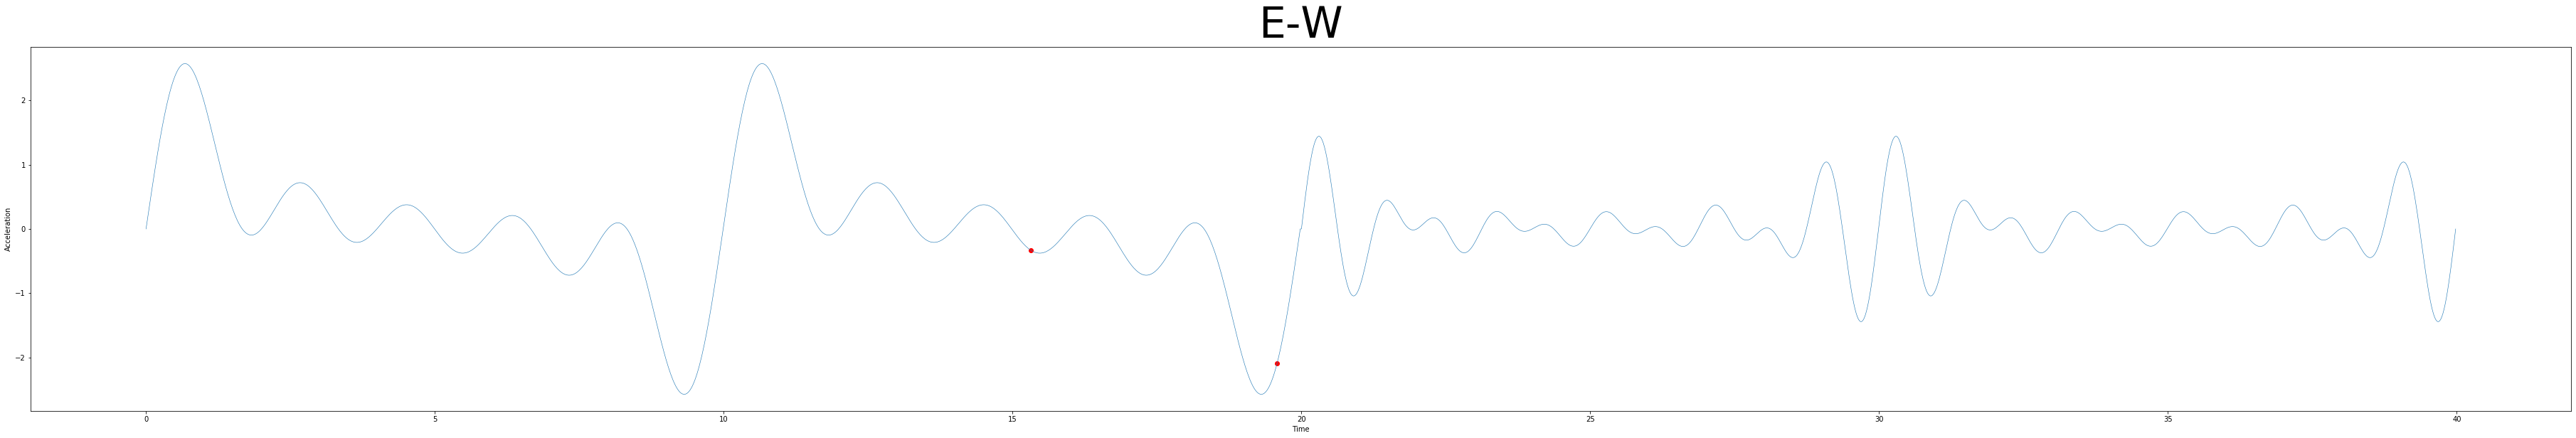

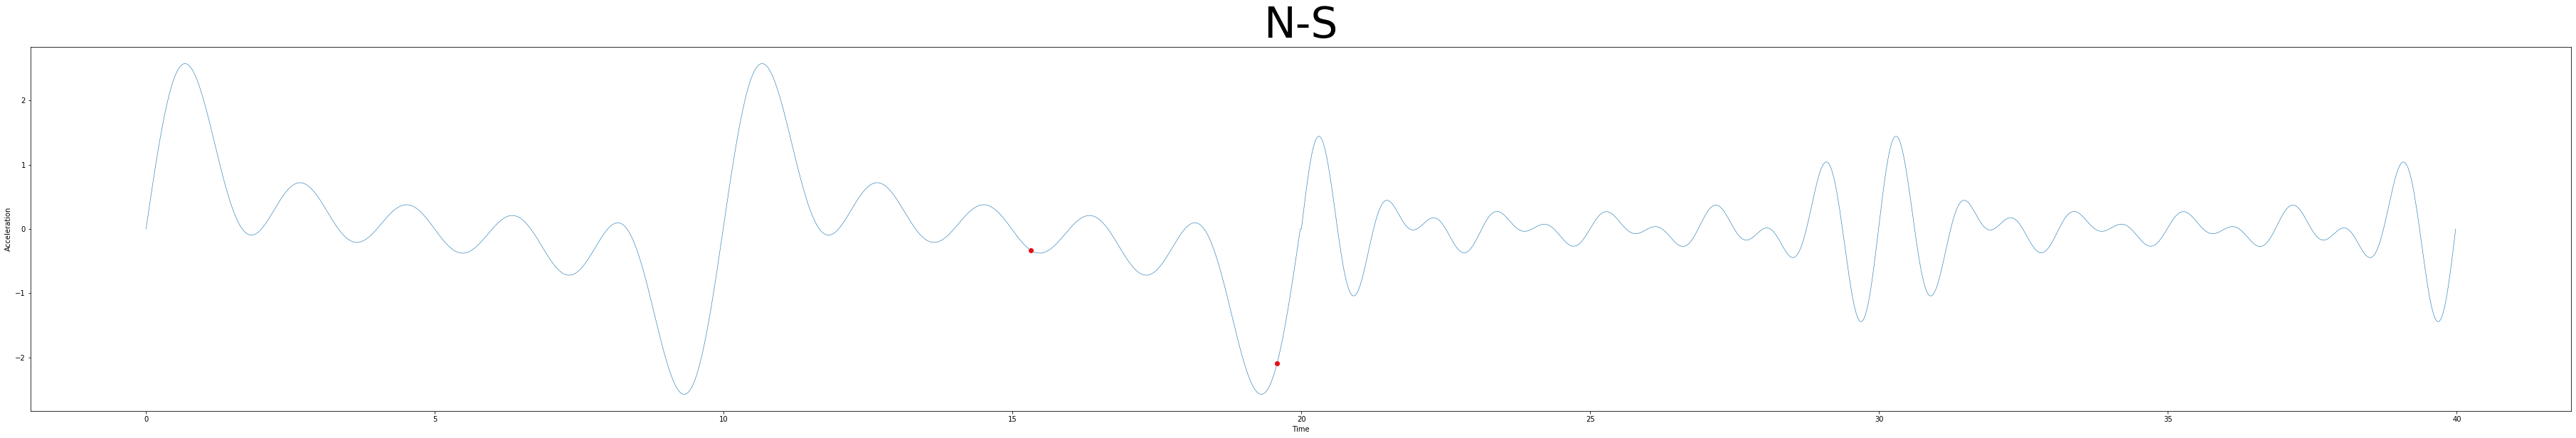

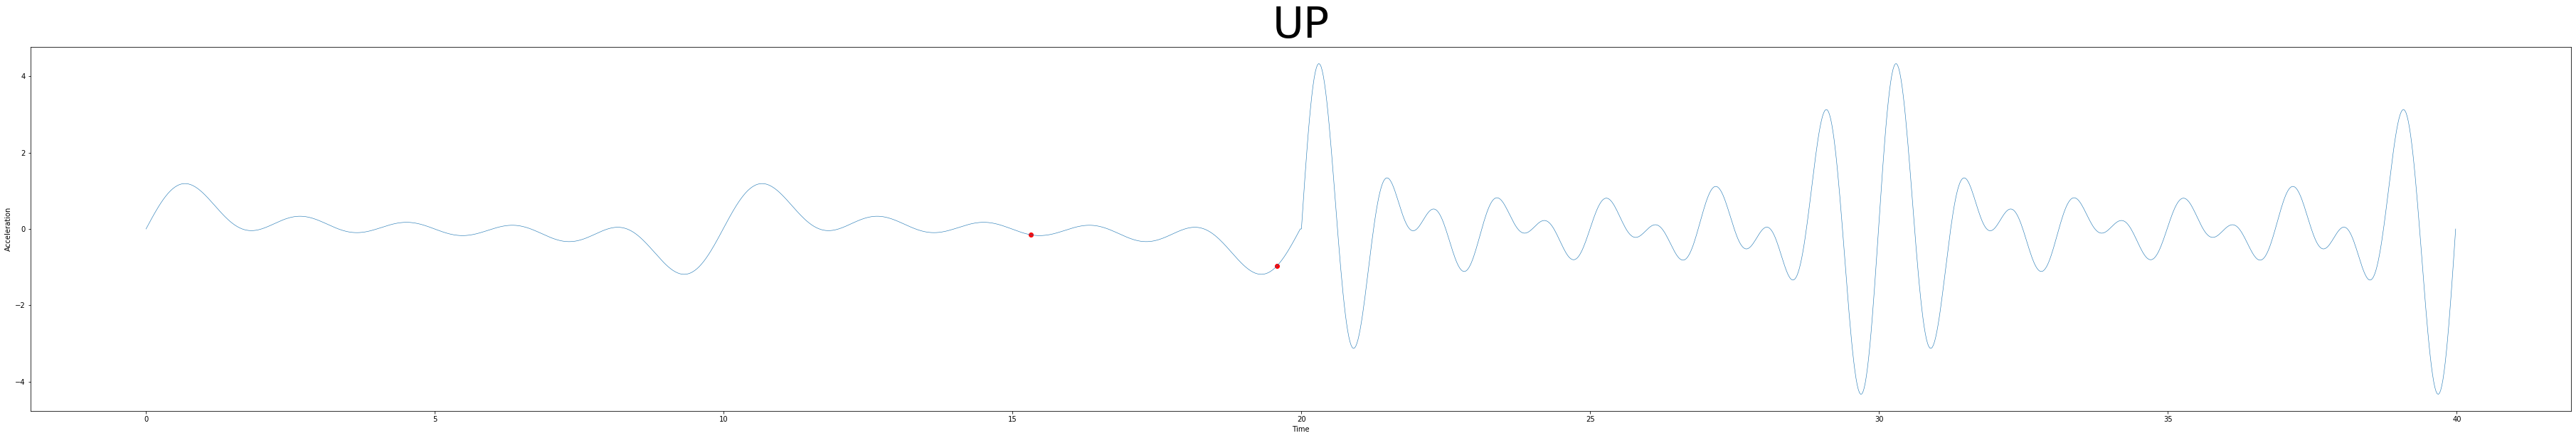

In [16]:
for i,j in enumerate(Input_signal):
    markP_S(j,i,d,40,0.02)

In [17]:
p,s=simple_P_and_S(signal_x,signal_y,signal_z,time_period=0.02,thresh_p_high=0.15,thresh_s_low=0.45,thresh_s_high=0.90)

1.41421356237
1.41421356237
1.41421356237


C:\Users\anmol harshana\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part


In [18]:
print(p,'\n',s)

[] 
 [56, 56, 1024]


There seem to be no p-wave by this function , the reason is simple: The amplitudes of wave are much higher.

In [19]:
p,s=simple_P_and_S(Input_signal[1],Input_signal[0],Input_signal[2],time_period=0.02,thresh_p_high=0.45,thresh_s_low=0.45,thresh_s_high=0.90)

1.41421356237
1.41421356237
1.41421356237


C:\Users\anmol harshana\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part


In [20]:
print(p,'\t',s,'\n','Time ','\n',np.array(p)*0.02,np.array(s)*0.02)

[67, 67, 34] 	 [56, 56, 1024] 
 Time  
 [ 1.34  1.34  0.68] [  1.12   1.12  20.48]


Simple judgement may tell that in this case the vertical component gives correct values for p and s arrival as for the other 2 s arrives before p, which is impossible. Now adding noise and testing

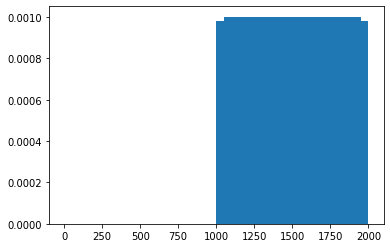

In [21]:
s_loc=list()
for i in range(np.size(Input_signal[0])-1):
    if(abs(Input_signal[2][i])>np.sqrt(Input_signal[1][i]**2+Input_signal[0][i]**2)):
        s_loc.append(int(i))
plt.hist(s_loc,bins=40,range=(0,2000),density=True) ;

Clearly,this rough method also works like an indication whether we are wrong or right.

In [22]:
#generating random noise in the signal

noise=-2*np.random.random(2000)+2*np.ones(2000)#an array of 2000 random numbers between 0 and 2.

In [23]:
signal_x=noise+signal_x
signal_y=noise+signal_y
signal_z=noise+signal_z

In [24]:
p=ar_pick(signal_z,signal_y,signal_x, samp_rate=50, f1=0.02, f2=25, lta_p=20, sta_p=1, lta_s=5, sta_s=1, m_p=2 ,m_s=2, l_p=5, l_s=5, s_pick=True)
print(p)

(15.359999656677246, 19.200000762939453)


The value seems to be nearly same, so this function can work even in noisy data.

In [25]:
Input_signal=list()
Input_signal.append(signal_x)
Input_signal.append(signal_y)
Input_signal.append(signal_z)
Input_signal=np.array(Input_signal)

In [26]:
p,s=simple_P_and_S(signal_x,signal_y,signal_z,time_period=0.02,thresh_p_high=0.15,thresh_s_low=0.45,thresh_s_high=0.90)

1.41421356237
1.41421356237
1.41421356237


C:\Users\anmol harshana\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part


In [27]:
print(p,'\n',s)

[] 
 [5, 5, 5]


Clearly, this impossible, The fucntion fails on noisy data in this case, so we would have to filter data.

C:\Users\anmol harshana\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


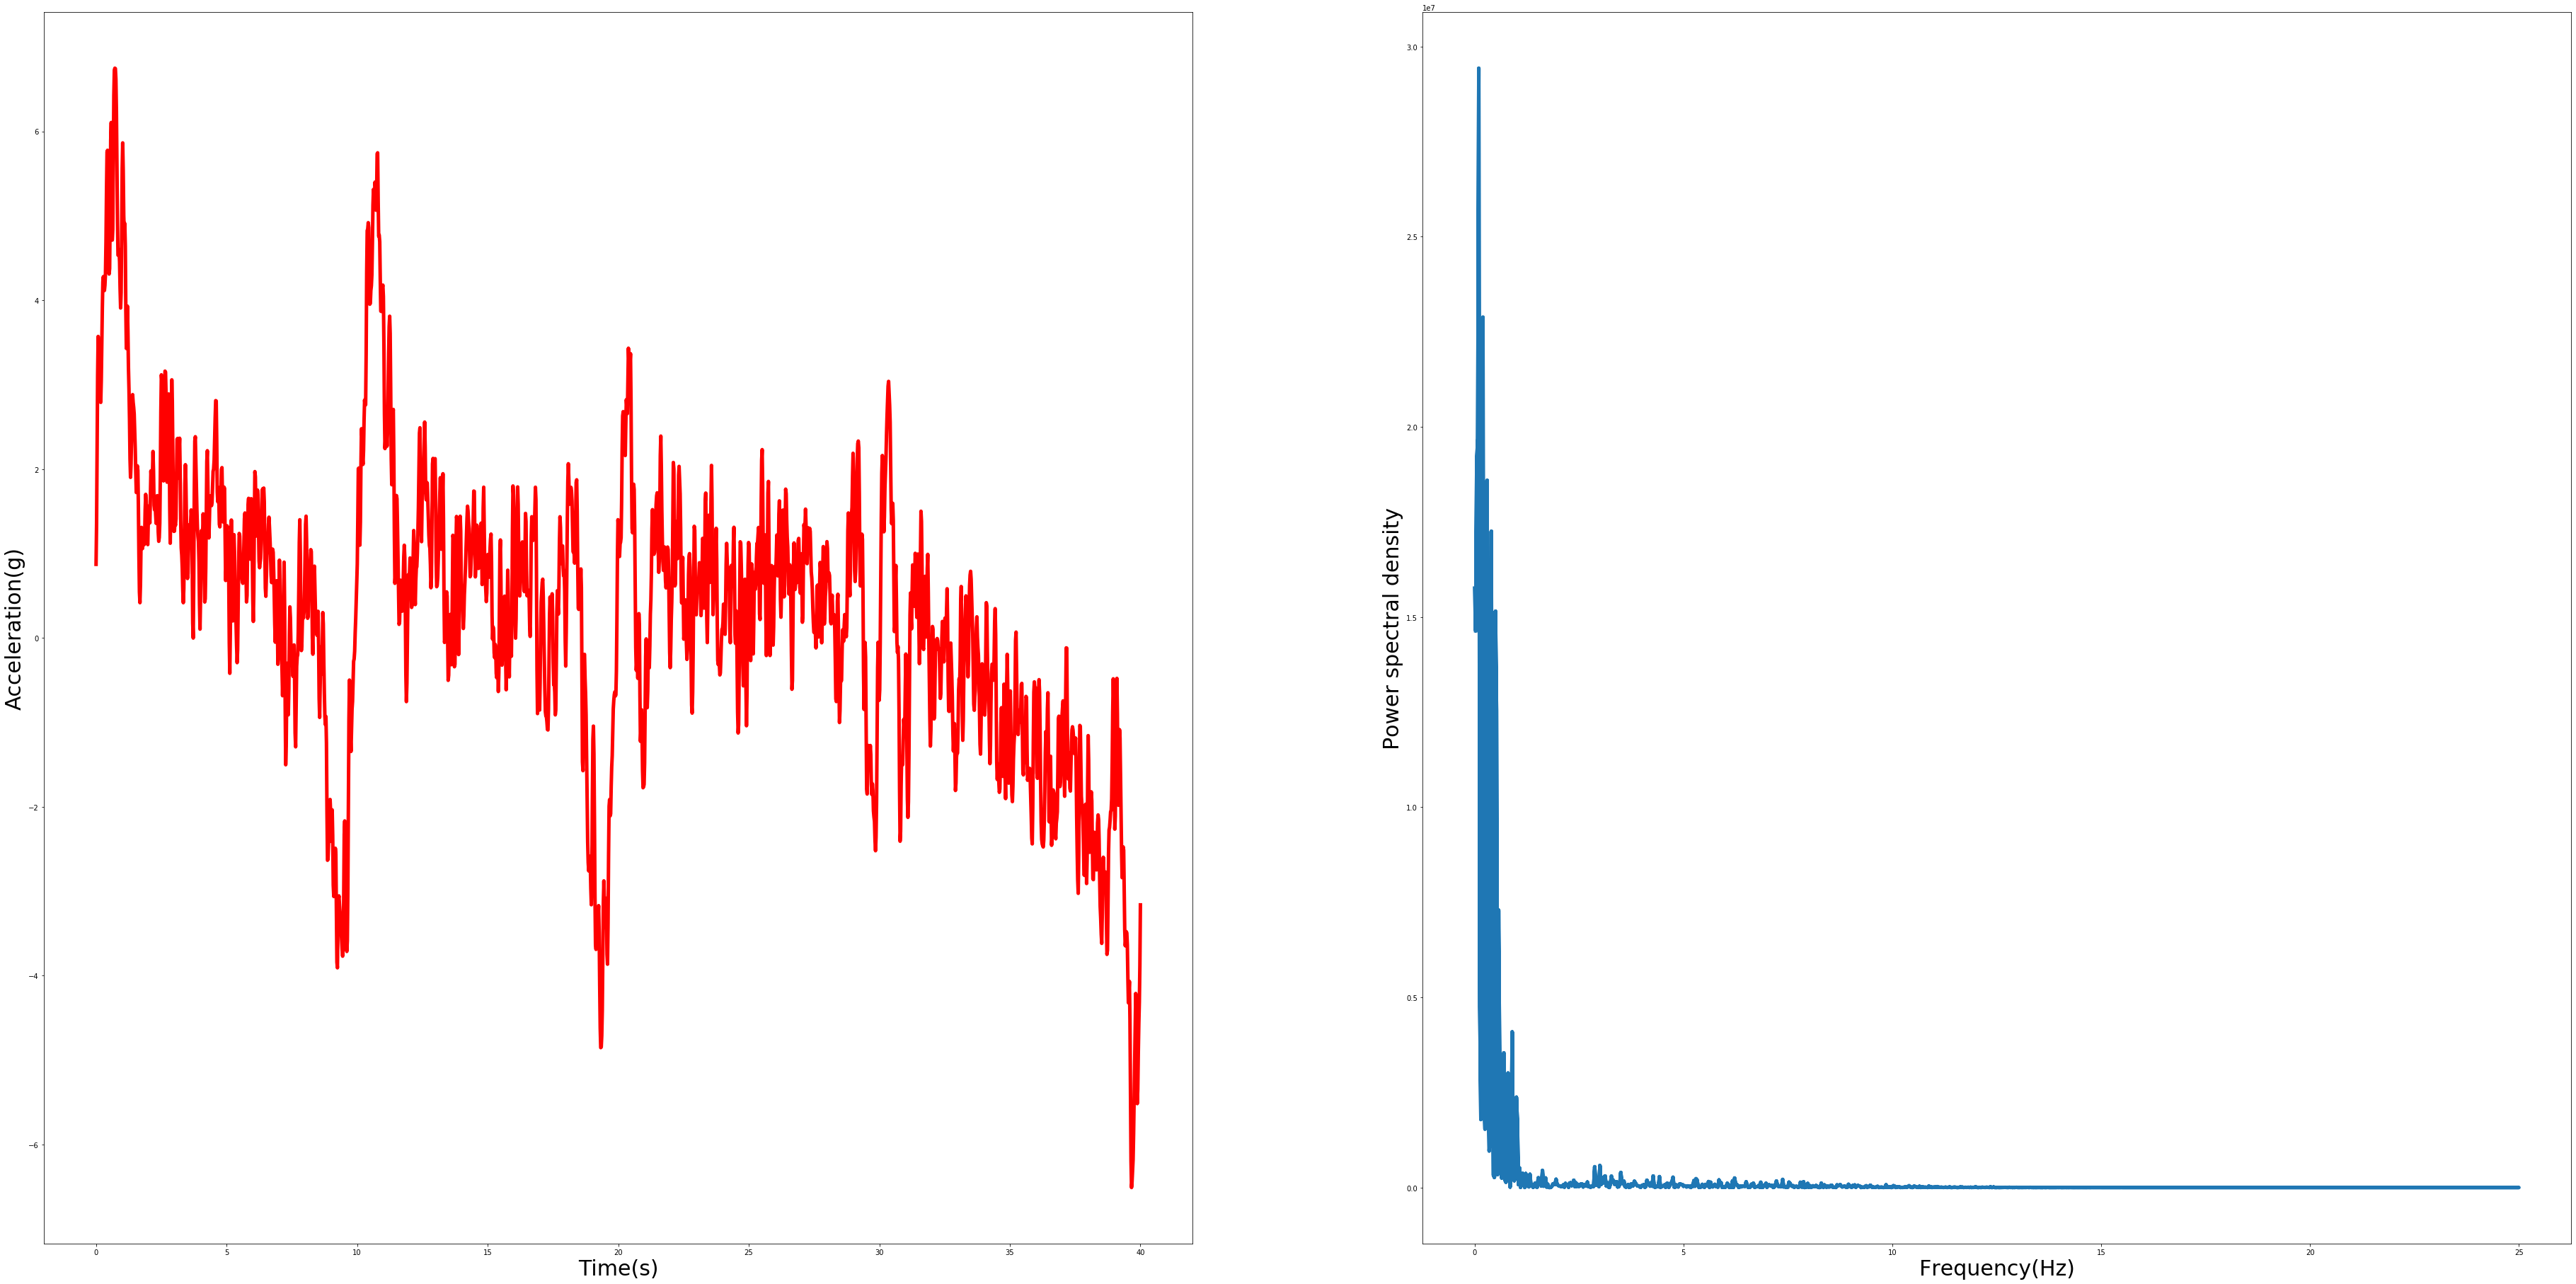

In [28]:
plot_filtered_seismogram(signal_x,lower_Freq=0.02,higher_Freq=10,Time_lag=0.02,order=2)

From the above seismogram it appears like most of the wave is of less than 2.5 Hz.

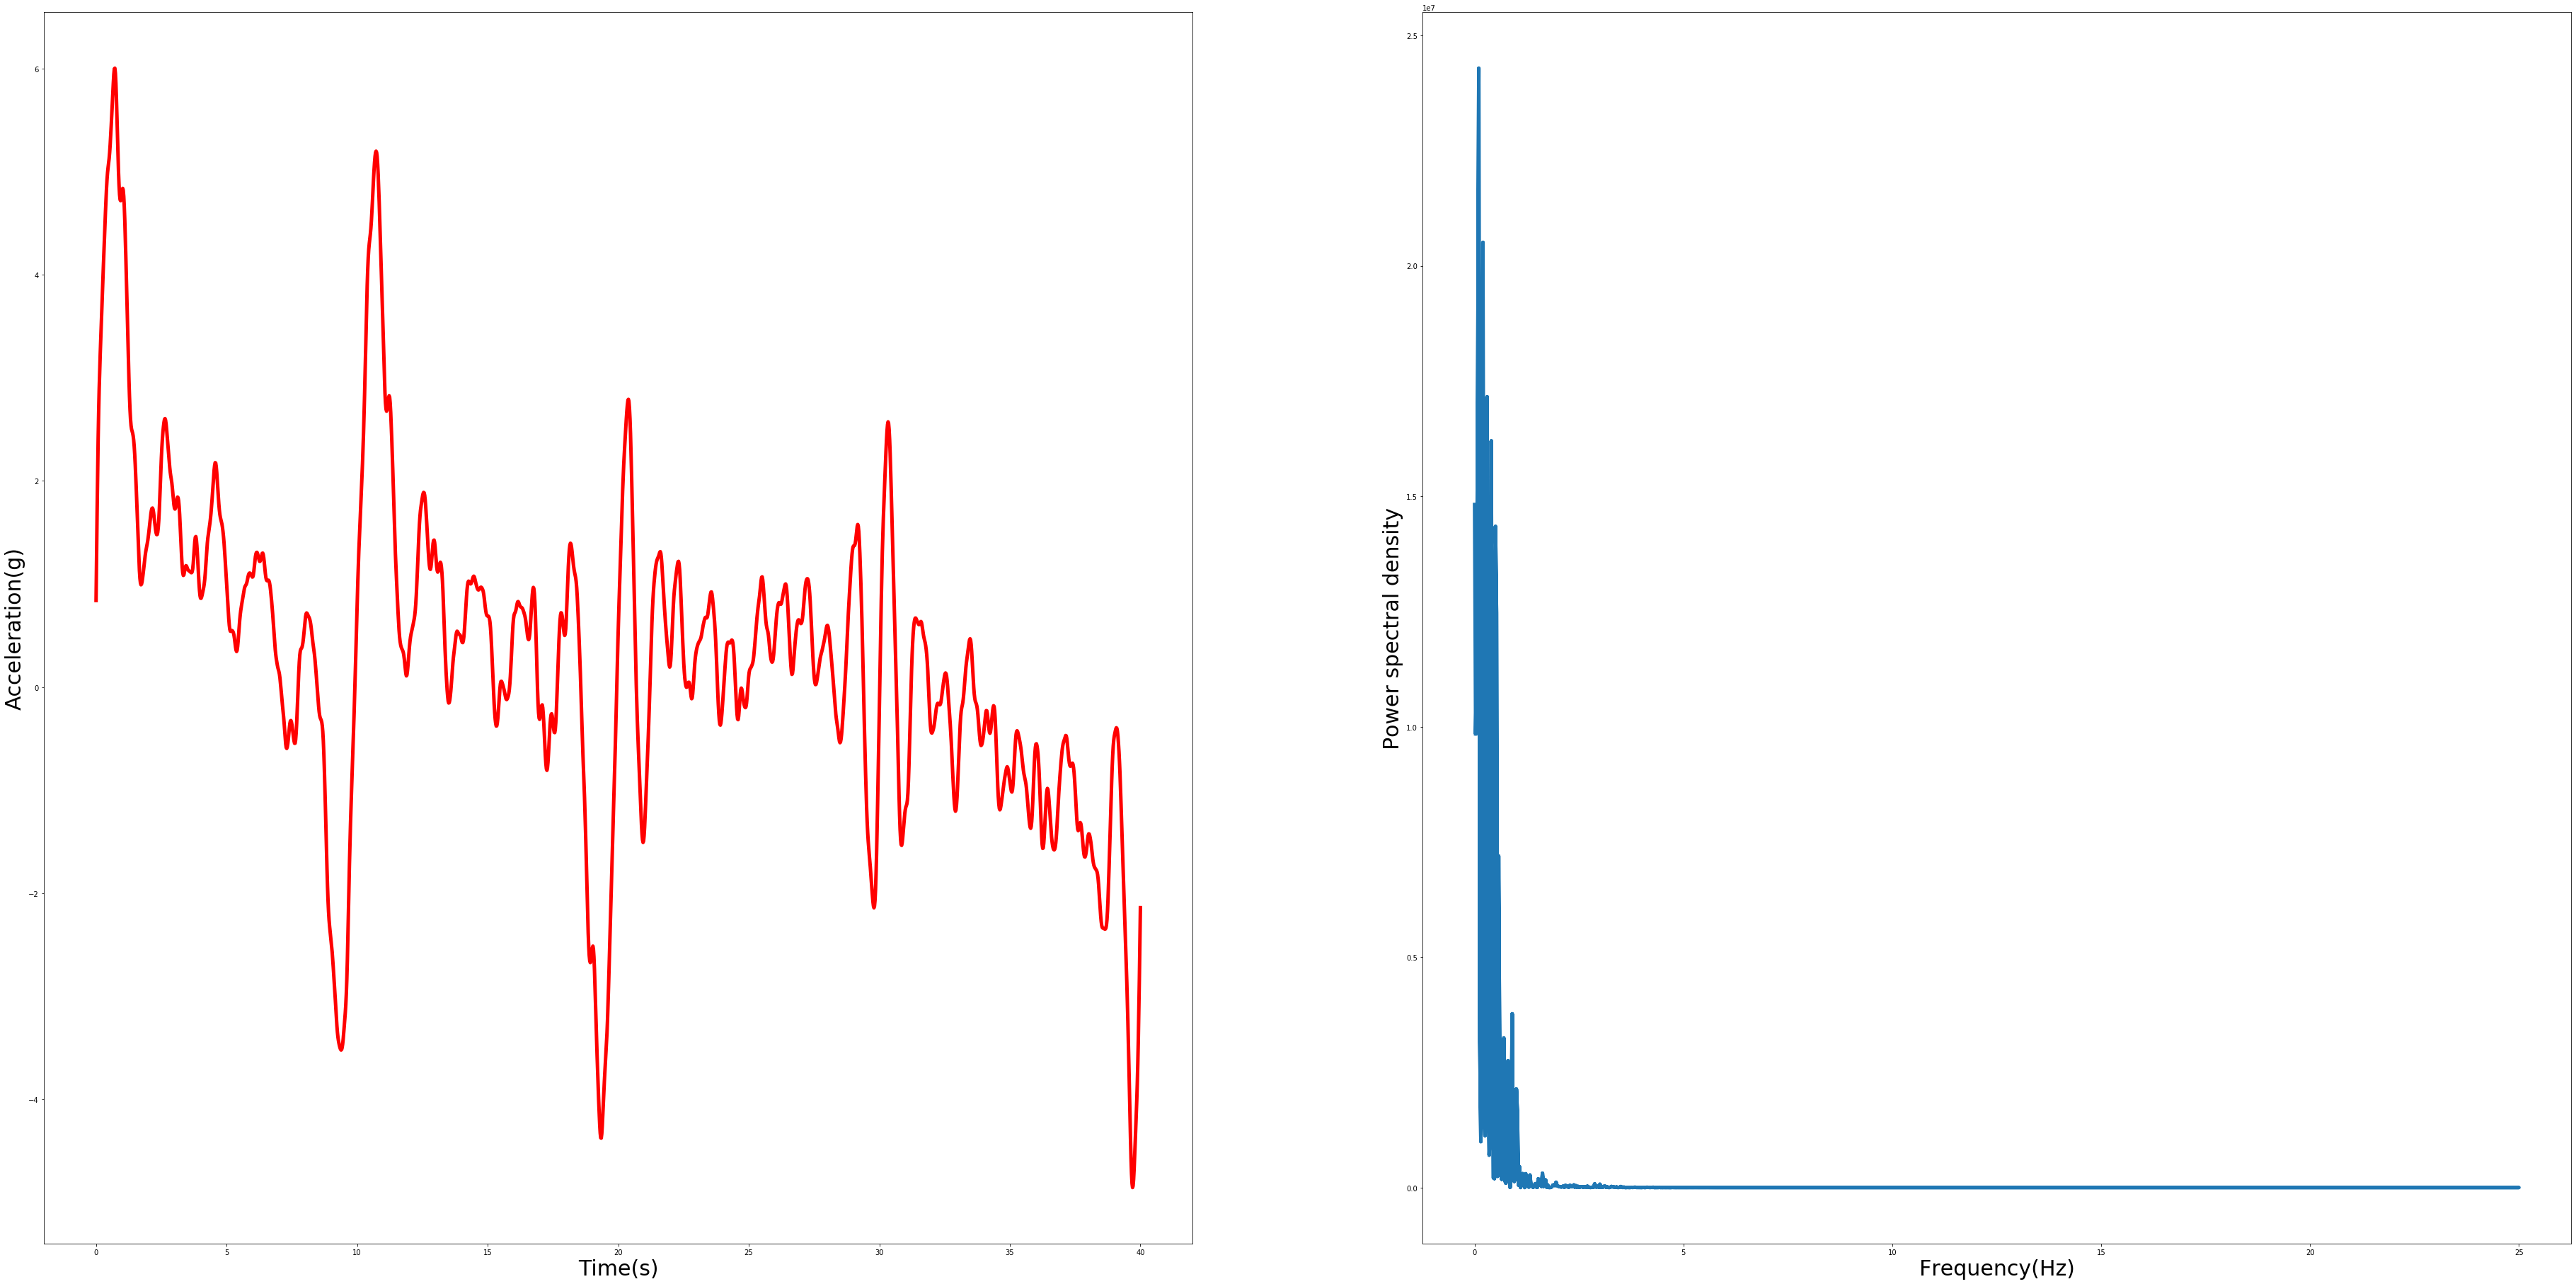

In [29]:
plot_filtered_seismogram(signal_x,lower_Freq=0.02,higher_Freq=2.5,Time_lag=0.02,order=2)

In [30]:
#Now filtering the data
#Detrending
signal_filt1=np.array(Input_signal)
signal_filt=np.array(Input_signal)
butter_filter=butter(2,Wn=(0.02/50,2.5/50),btype='bandpass')# specifying butter filter
for i in range(3):
    signal_filt1[i]=Input_signal[i]-np.mean(Input_signal[i])*np.ones_like(Input_signal[i]) 
    signal_filt[i]=np.sqrt(8/3)*filtfilt(butter_filter[0],butter_filter[1],signal_filt[i])

In [31]:
p=ar_pick(signal_filt[2],signal_filt[1],signal_filt[0], samp_rate=50, f1=0.02, f2=25, lta_p=20, sta_p=1, lta_s=5, sta_s=1, m_p=2 ,m_s=2, l_p=5, l_s=5, s_pick=True)
print(p)

(15.140000343322754, 29.899999618530273)


In [32]:
p,s=simple_P_and_S(signal_filt[2],signal_filt[1],signal_filt[0],time_period=0.02,thresh_p_high=0.3,thresh_s_low=0.45,thresh_s_high=0.90)

1.41421356237
1.41421356237
1.41421356237


C:\Users\anmol harshana\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part


In [33]:
print(p,'\t',s,'\n','Time ','\n',np.array(p)*0.02,np.array(s)*0.02)

[] 	 [35, 62, 62] 
 Time  
 [] [ 0.7   1.24  1.24]


Clearly, This is too bad a performance even after filtering.
Now let's consider a different situation.

In [34]:
signal_x_new=np.zeros(shape=(3,1000))
signal_y_new=np.zeros(shape=(3,1000))
signal_z_new=np.zeros(shape=(3,1000))


In [35]:
signal_x_new[0]=-1*np.random.random(1000)+np.ones(1000)# generating some random sequence before wave arrivals
signal_y_new[0]=-1*np.random.random(1000)+np.ones(1000)
signal_z_new[0]=-1*np.random.random(1000)+np.ones(1000)

In [36]:
signal_x_new[1]=signal_x[0:1000:1]# storing the initial thousand values of previous signal
signal_y_new[1]=signal_y[0:1000:1]
signal_z_new[1]=signal_z[0:1000:1]
signal_x_new[2]=signal_x[1000:2000:1]
signal_y_new[2]=signal_y[1000:2000:1]
signal_z_new[2]=signal_z[1000:2000:1]

In [37]:
#Flattening the array
signal_x_new=signal_x_new.ravel()
signal_y_new=signal_y_new.ravel()
signal_z_new=signal_z_new.ravel()


In [38]:
Input_new=list()
Input_new.append(signal_x_new)
Input_new.append(signal_y_new)
Input_new.append(signal_z_new)
Input_new=np.array(Input_new)

In [39]:
p_s=ar_pick(signal_z_new,signal_y_new,signal_x_new, samp_rate=50, f1=0.02, f2=25, lta_p=20, sta_p=1, lta_s=5, sta_s=1, m_p=2 ,m_s=2, l_p=5, l_s=5, s_pick=True)
print(p_s)

(15.720000267028809, 29.399999618530273)


In [40]:
#Converting p values to indices 
d=list()
d.append(int(p_s[0]/0.02)+1)
d.append(int(p_s[1]/0.02)+1)

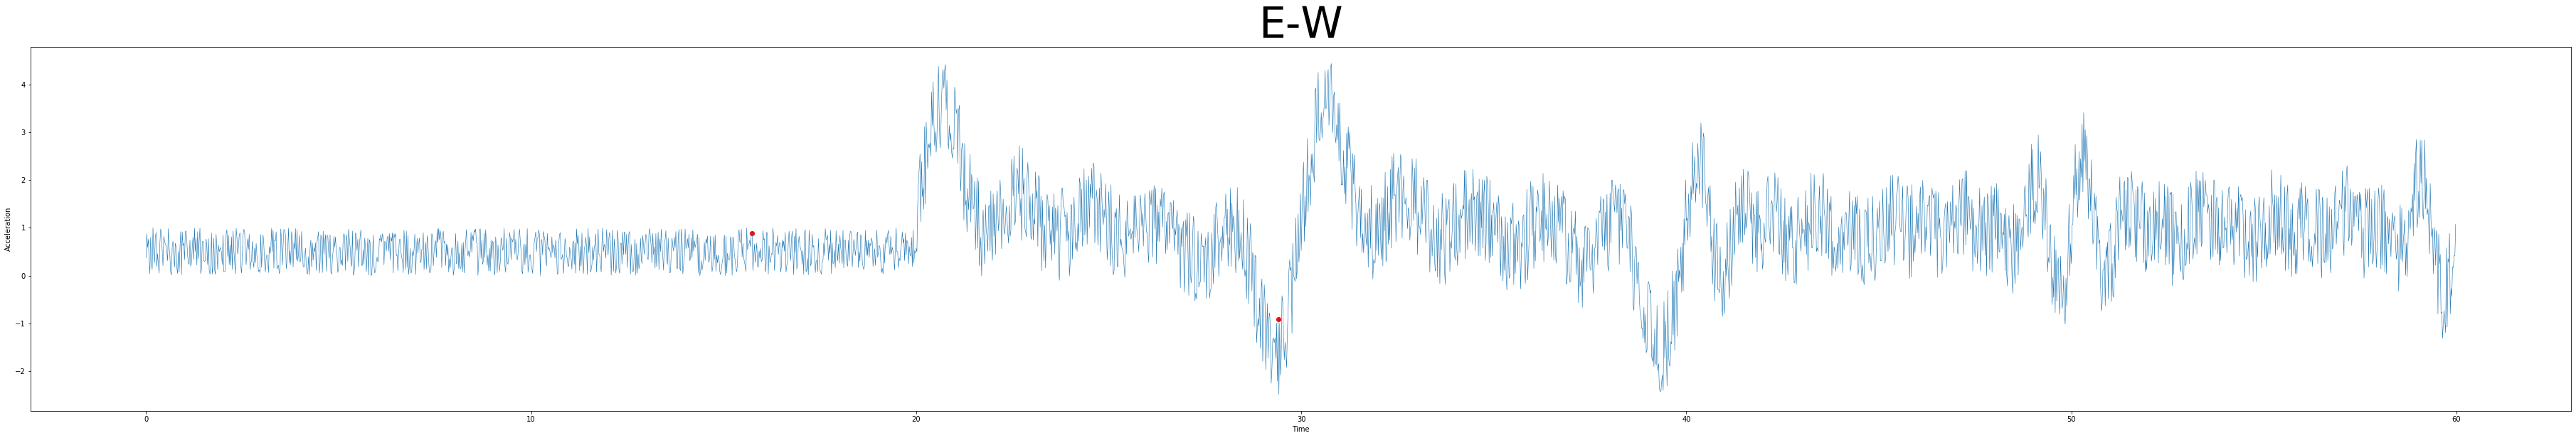

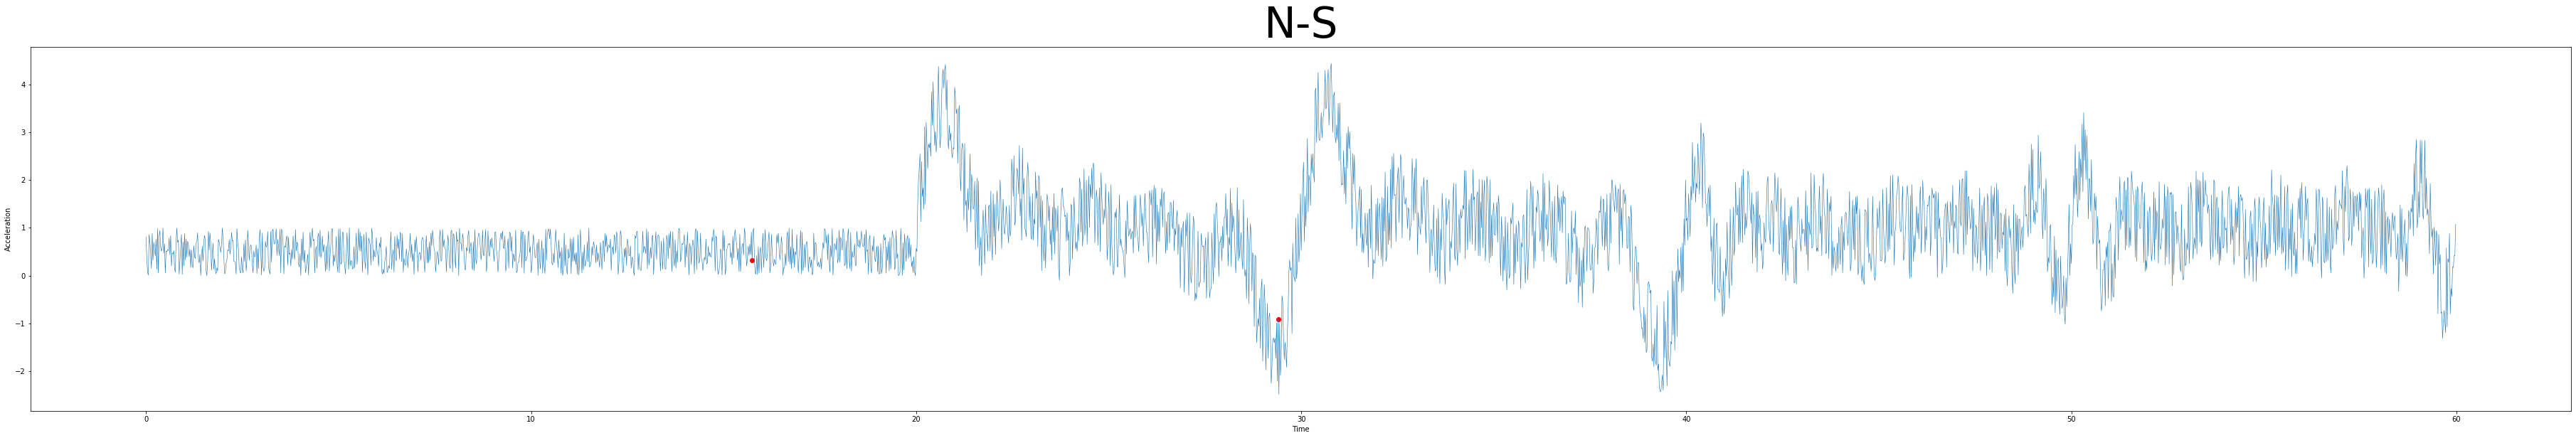

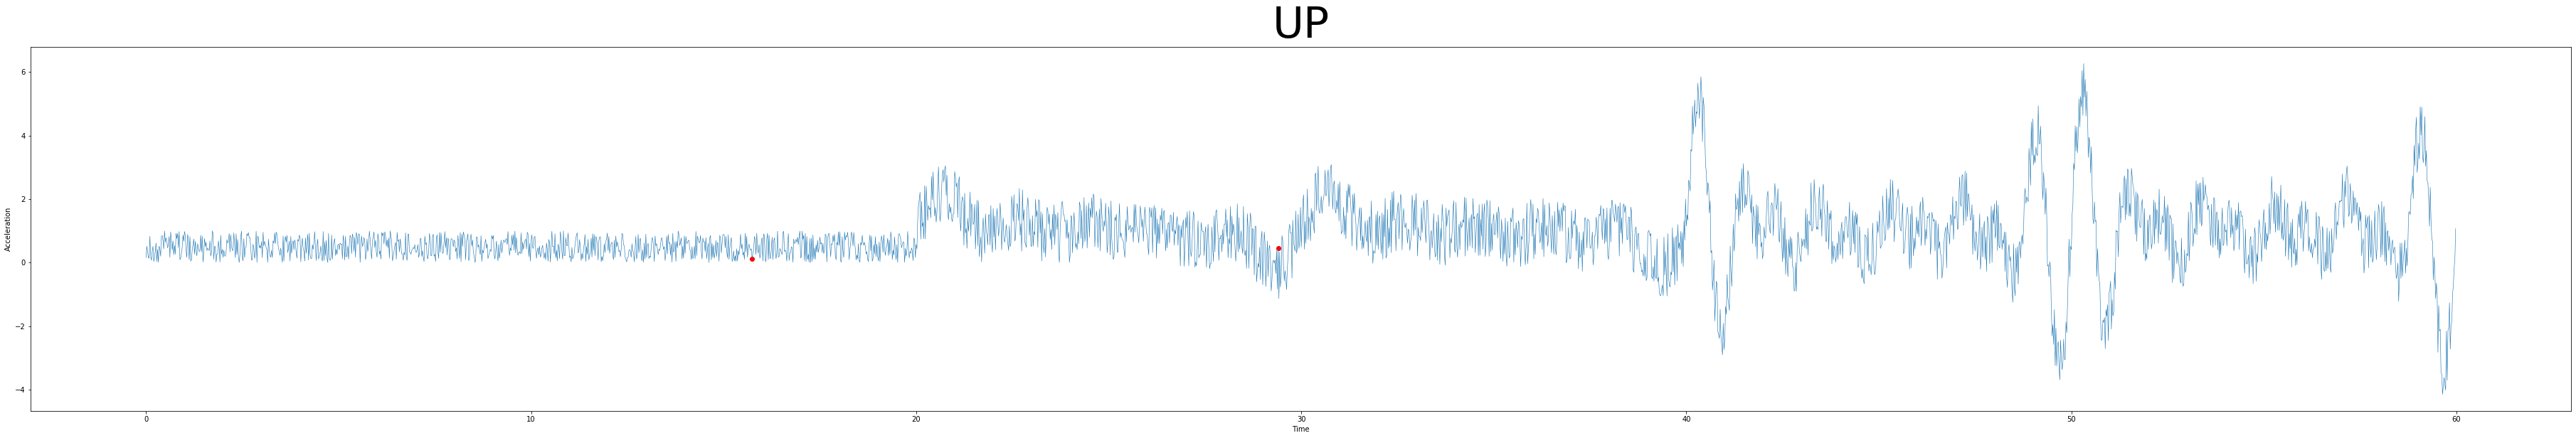

In [41]:
for i in range(3):
    markP_S(Input_new[i],i,d,time_limit=60,interval=0.02)

In [42]:
p,s=p,s=simple_P_and_S(Input_new[2],Input_new[1],Input_new[0],time_period=0.02,thresh_p_high=0.3,thresh_s_low=0.45,thresh_s_high=0.90)

1.41421356237
1.41421356237
1.41421356237


C:\Users\anmol harshana\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part


In [43]:
print(p,'\t',s,'\n','Time ','\n',np.array(p)*0.02,np.array(s)*0.02)

[1, 0, 1] 	 [1005, 1005, 1005] 
 Time  
 [ 0.02  0.    0.02] [ 20.1  20.1  20.1]


In this case we see that both the algorithms fail, So proper cliping of data is necessary for marking p and s wave.But still we find that ar_pick is much better in this respect.


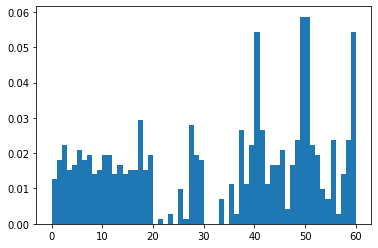

In [44]:

s_loc=list()
for i in range(np.size(Input_new[0])-1):
    if(abs(Input_new[2][i])>np.sqrt(Input_new[1][i]**2+Input_new[0][i]**2)):
        s_loc.append(int(i)*0.02)
plt.hist(s_loc,bins=60,range=(0,60),density=True);   

Now working on real Data. Though I have used the same Earthquake data multiple times, It still causes me trouble and I suspect that the data in the three streams actually don't have p wave at all. 

In [45]:
datafile1=pd.read_csv('elcentro_EW.dat',sep=' ')#the east west component of seismic wave
datafile2=pd.read_csv('elcentro_NS.dat',sep=' ')#the north-south component of seismic wave
datafile3=pd.read_csv('elcentro_UP.dat',sep=' ')#the vertical component of seismic wave
print('For data file 1:','\n',datafile1.describe())
print('For data file 2:','\n',datafile2.describe())
print('For data file 3:','\n',datafile3.describe())

For data file 1: 
               time  acceleration
count  2674.000000   2674.000000
mean     26.730000     -0.000218
std      15.441233      0.039617
min       0.000000     -0.182526
25%      13.365000     -0.013358
50%      26.730000     -0.000102
75%      40.095000      0.011115
max      53.460000      0.214137
For data file 2: 
               time  acceleration
count  2688.000000   2688.000000
mean     26.870000      0.000049
std      15.522062      0.046928
min       0.000000     -0.268181
25%      13.435000     -0.012746
50%      26.870000     -0.000306
75%      40.305000      0.010936
max      53.740000      0.348737
For data file 3: 
               time  acceleration
count  2690.000000   2690.000000
mean     26.890000     -0.000049
std      15.533609      0.024105
min       0.000000     -0.210058
25%      13.445000     -0.004665
50%      26.890000     -0.000102
75%      40.335000      0.004589
max      53.780000      0.193743


2674
2700


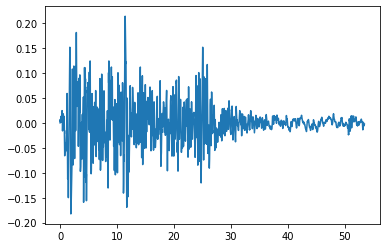

In [46]:
time=datafile1.iloc[0::,0]#time
accl_EW=datafile1.iloc[0::,1]#acceleration
plt.plot(time,accl_EW)
print(np.size(accl_EW))
accl_EW=list(accl_EW)
accl_EW=np.array(accl_EW)
accl_EW=accl_EW-np.ones(np.size(accl_EW))*np.mean(accl_EW)#detrending the data  
accl_EW=list(accl_EW)
for i in range(26):
    accl_EW.append(0)
print(np.size(accl_EW))

2688
2700


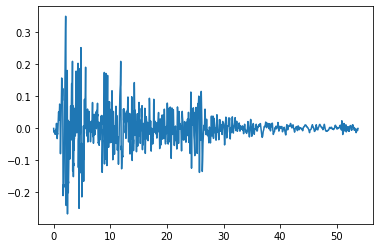

In [47]:
time=datafile2.iloc[0::,0]#time
accl_NS=datafile2.iloc[0::,1]#acceleration
plt.plot(time,accl_NS)
print(np.size(accl_NS))
accl_NS=list(accl_NS)
accl_NS=np.array(accl_NS)
accl_NS=accl_NS-np.ones(np.size(accl_NS))*np.mean(accl_NS)#detrending the data  
accl_NS=list(accl_NS)
for i in range(12):
    accl_NS.append(0)
print(np.size(accl_NS))

2690
2700


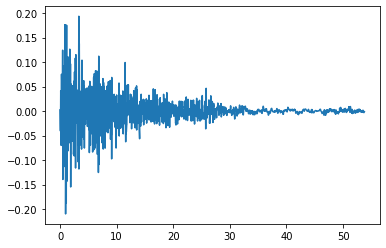

In [48]:
time=datafile3.iloc[0::,0]#time
accl_UP=datafile3.iloc[0::,1]#acceleration
plt.plot(time,accl_UP)
print(np.size(accl_UP))
accl_UP=list(accl_UP)
accl_UP=np.array(accl_UP)
accl_UP=accl_UP-np.ones(np.size(accl_UP))*np.mean(accl_UP)#detrending the data  
accl_UP=list(accl_UP)
for i in range(10):
    accl_UP.append(0)
print(np.size(accl_UP))

In [49]:
Input=list()
Input.append(accl_EW)
Input.append(accl_NS)
Input.append(accl_UP)
Input=np.array(Input)

In [50]:
from obspy.signal.trigger import ar_pick
p_s=ar_pick(Input[2],Input[1],Input[0], samp_rate=50, f1=0.02, f2=20, lta_p=25, sta_p=1, lta_s=5, sta_s=1, m_p=2 ,m_s=2, l_p=5, l_s=5, s_pick=True)
print(p_s)

(0.03999999910593033, 6.639999866485596)


In [51]:
#Converting p values to indices 
d=list()
d.append(int(p_s[0]/0.02)+1)
d.append(int(p_s[1]/0.02)+1)

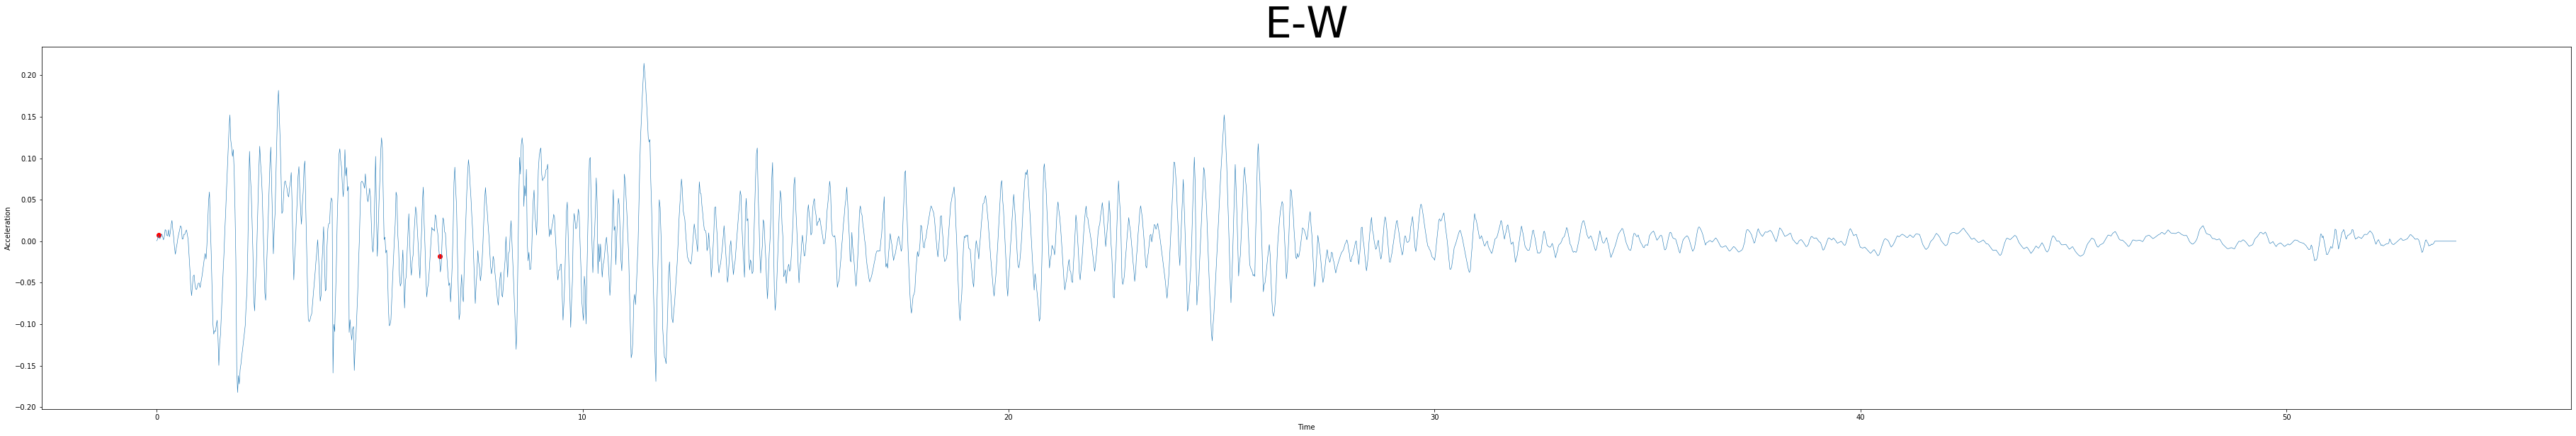

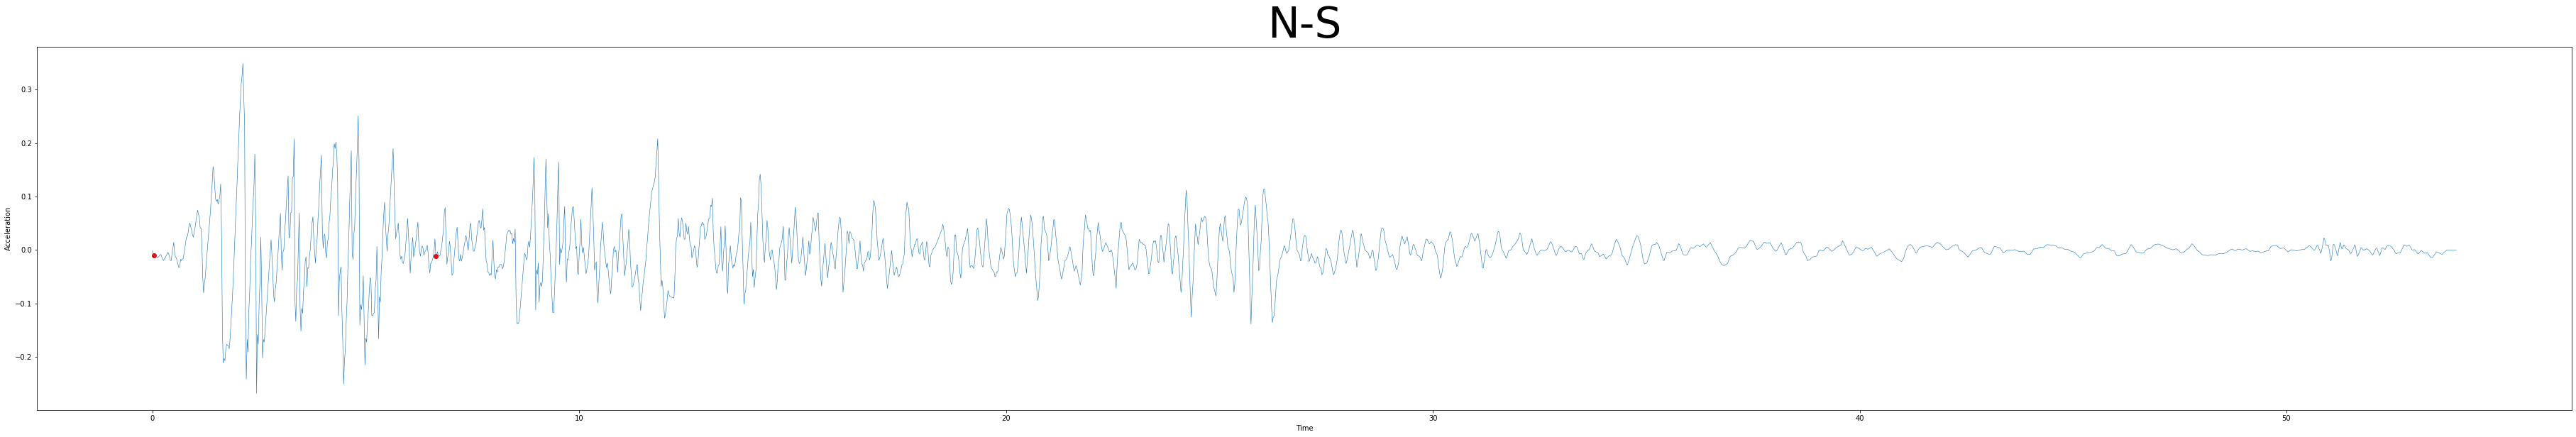

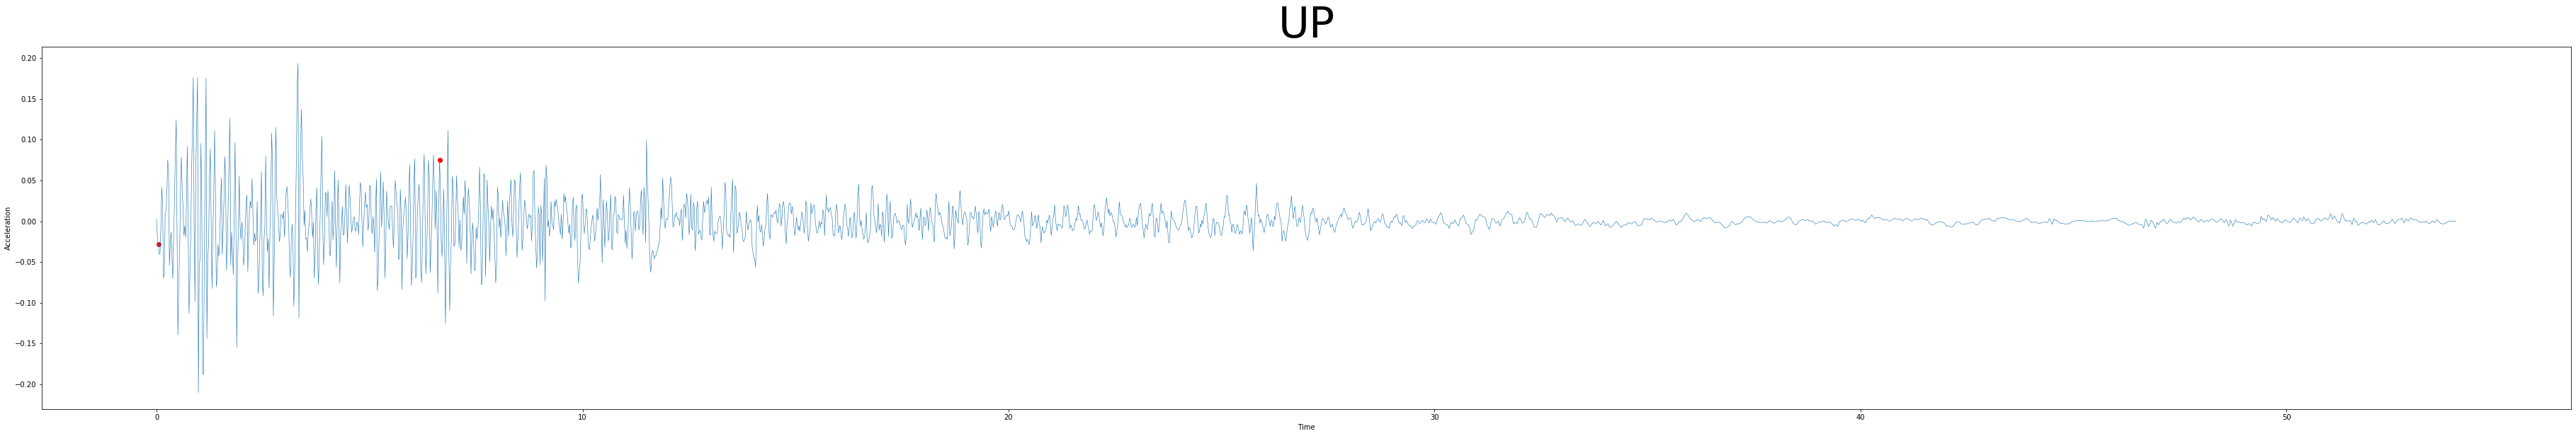

In [52]:
for i in range(3):
    markP_S(Input[i],i,d,time_limit=54,interval=0.02)

We see that it nicely marks p and s wave.

In [53]:
p,s=p,s=simple_P_and_S(Input[2],Input[1],Input[0],time_period=0.02,thresh_p_high=0.3,thresh_s_low=0.45,thresh_s_high=0.90)
print(p,'\t',s,'\n','Time ','\n',np.array(p)*0.02,np.array(s)*0.02)

1.41421356237
1.41421356237
1.41421356237
[3, 1, 2] 	 [8, 71, 67] 
 Time  
 [ 0.06  0.02  0.04] [ 0.16  1.42  1.34]


C:\Users\anmol harshana\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part


From the simpler algorithm value appear to be  a bit less than that from ar_pick method.

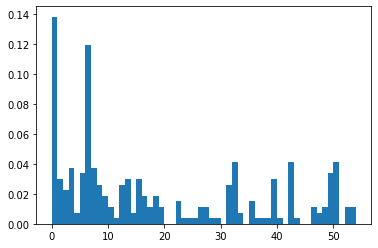

In [54]:
s_loc=list()
for i in range(np.size(Input[0])-1):
    if(abs(Input[2][i])>np.sqrt(Input[1][i]**2+Input[0][i]**2)):
        s_loc.append(int(i)*0.02)
plt.hist(s_loc,bins=54,range=(0,54),density=True);   

It is here that we find some concern, In the data given the s_wave seems to be present from the beginning, But pardoning that we find that the s wave prediction around 3 to 7 is still tolerable.

From the various representations here, it is clear that there is no absolute way for marking p and s wave, but different algorithms have different limitations, So We cannot go blindly by any one algorithm, So in the end I have decided to keep both the algorithms but for further calculations, It might be safer to go with ar_pick from obspy due to the following reasons:

1. Consistent results even when data is noisy.

2. The values detected are usually less than the expected value which ensures that we don't leave any valuable observation behind. 